In [10]:
""" Generalized predictive coding with 1D CNNs """
""" Linear Audio prediction """

import torch
import torch.nn as nn
import numpy as np
import librosa as lbr
import matplotlib.pyplot as plt
import IPython.display as ipd
from GeneralizedLPC import *
import seaborn as sns
sns.set_theme()

# audio settings
normalize_audio = True
normalize_input = False

# model settings
kernel_size = 2
use_gc = True
EPOCHS = 1000
LR = 0.01
OPTIMISER = torch.optim.Adam
LOSS = nn.L1Loss(reduction="mean") #nn.MSELoss(reduction='sum')

identity_output = False # setting this to True is crucial for reconstruction atm

# generalized coordinates settings
length = 1000
GEN_COORDS = 5 # 5
HIGHEST_COORD = 5 # 5
input_units = 1; dt = 1; t = 0; b_size = 1

In [11]:
filename = lbr.ex('libri2')
audio, samplerate = lbr.load(filename, offset=15.0, duration=1)
if normalize_audio: audio/=np.abs(audio).max()
audio = audio[10000:]

predictions_list, err_list, sigpow_list, SEPR_list, SEPR_CF_list = [], [], [], [], []

for repeat in range(1):
    for start in range(0, audio.shape[0], length):
        end = start + length
        audiosh = audio[start:end]

        # normalize
        if normalize_input: audiosh/=np.abs(audiosh).max()

        # embed audio into generalized coordinates
        Y0_gc, YGC_in, YGC_in_padded = embed_audio(audiosh, GEN_COORDS, dt, t, kernel_size, length, b_size, input_units, plot=False, use_gc=True)
        inputs = [Y0_gc] + YGC_in_padded

        # train
        model = run(inputs, YGC_in, use_gc, kernel_size, optimiser=OPTIMISER, epochs=EPOCHS, lr=LR,
                    identity_output=identity_output, loss_fn = LOSS)

        # evaluate
        predictions, err, sigpow, SEPR = evaluate(model, inputs, use_gc, Y0_gc, kernel_size, highest_order=HIGHEST_COORD, print_result=False, plot=False)

        # closed form solution for comparison
        SEPR_CF, xrec_CF, e_CF = closed_form(audiosh, LENGTH=length-kernel_size, KERNEL_SIZE=kernel_size, print_result=False, plot=False)

        print("MSE", err.item(), "MSP", sigpow.item(), "SEPR", SEPR.item(), "SEPR CF", SEPR_CF)

        predictions_list.append(predictions); err_list.append(err.item())
        sigpow_list.append(sigpow.item()); SEPR_list.append(SEPR.item()); SEPR_CF_list.append(SEPR_CF)
        if start >= 0: break

mean_SEPR = np.asarray(SEPR_list).mean()
mean_SEPR_CF = np.asarray(SEPR_CF_list).mean()
max_SEPR_CF = np.asarray(SEPR_list).max()
print("Signal to Error Power Ratio: Model mean ", mean_SEPR, " -  Closed form", mean_SEPR_CF, " Model max ", max_SEPR_CF)


MSE 4.849215838476084e-05 MSP 0.013730663806200027 SEPR 283.1522521972656 SEPR CF 133.74729601860005
Signal to Error Power Ratio: Model mean  283.1522521972656  -  Closed form 133.74729601860005  Model max  283.1522521972656


In [12]:
print("B", model.B[0].weight.detach())
print("C", model.C[0].weight.detach())
print("x", model.x0.detach().shape)
print("x'", model.hiddens[0].detach().shape)

B tensor([[[-0.4265,  0.4142]]])
C tensor([[[2.3109]]])
x torch.Size([1, 1, 995])
x' torch.Size([1, 1, 995])


In [13]:
""" Reconstruction with Generalized LPC
Reconstruction = Previous reconstruction + first order prediction + prediction error
todo use higher order predictions
"""

velocity_errors = [0 for _ in range(kernel_size-1)]
inputs_ = inputs[0].clone().detach()

for t in range(0, inputs[0].shape[-1]-kernel_size, 1):
    input = [inputs[0][:,:,t:t+kernel_size]]
    target = [inputs_[:,:,t+1:t+1+kernel_size]]

    pred = model(input)
    predicted_velocity = pred[1][0][0,0,:kernel_size].detach()
    predicted_target = input[0][0,0] + predicted_velocity

    velocity_error = (target[0][0,0]-input[0][0,0]) - predicted_velocity

    reconstructed_velocity = predicted_velocity + velocity_error
    reconstructed_target = input[0][0,0] + reconstructed_velocity

    reconstruction_error = target[0][0,0] - reconstructed_target

    velocity_errors.append(velocity_error[-1])

    # current reconstruction turns into next input
    inputs[0][:,:,t+kernel_size] == reconstructed_target[-1]

    if False:
        # the right most sample is the current prediction
        plt.plot(predicted_velocity[:kernel_size], label="predicted velocity")
        plt.plot(inputs[0][0,0,t:t+kernel_size], label="input: past prediction", linestyle="dotted")
        plt.plot(predicted_target, label="predicted_target", linestyle="-")
        plt.plot(reconstructed_target, label="reconstructed_target", linestyle="--")
        plt.plot(velocity_error, label="velocity error", linestyle="--")
        plt.plot(reconstruction_error, label="reconstruction error", linestyle="--")
        plt.plot(inputs[0][0,0,t+1:t+1+kernel_size], label="target", linestyle="dotted", linewidth=4)
        plt.legend(); plt.show()

if False:
    plt.plot(velocity_errors, label="velocity prediction error")
    plt.legend(); plt.show()

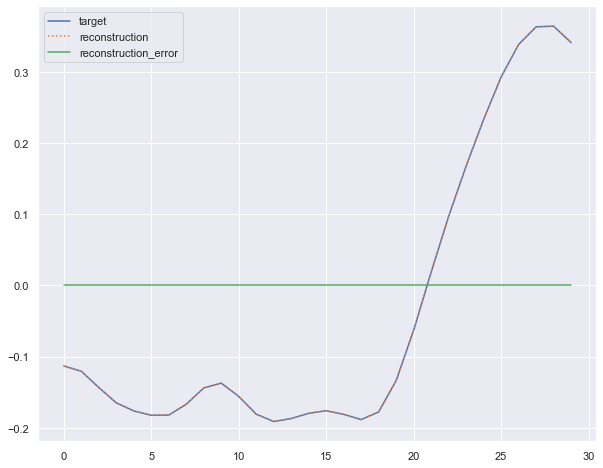

In [14]:
reconstruction = inputs[0][0,0,1:]
target = inputs_[0,0,1:]
reconstruction_error = target - reconstruction

end = 30
plt.figure(figsize=(10,8))
plt.plot(target[:end], label="target")
plt.plot(reconstruction[:end], label="reconstruction", linestyle="dotted")
plt.plot(reconstruction_error[:end], label="reconstruction_error")
plt.legend();


In [15]:
normalize = True # un-normalized error signal has low volume

length = 500
errors = predictions[:length].detach().numpy()-np.array(Y0_gc[0,0,1:length+1])
errors[:kernel_size] = 0.
print("Model prediction"); display(ipd.Audio(predictions.detach().numpy(), rate=samplerate, normalize=normalize))
print("Model prediction error"); display(ipd.Audio(errors, rate=samplerate, normalize=normalize))
print("Model reconstruction"); display(ipd.Audio(reconstruction, rate=samplerate, normalize=normalize))
print("Closed form reconstruction"); display(ipd.Audio(xrec_CF, rate=samplerate, normalize=normalize))

Model prediction


Model prediction error


Model reconstruction


Closed form reconstruction


In [149]:
# 10 inputs: (mean score)
# without GC: Signal to Error Power Ratio: Model  2581.992422103882  -  Closed form 6852.318571301918
# with GC 2: Signal to Error Power Ratio: Model  2583.291670885953  -  Closed form 6852.318571301918
# with GC 3: Signal to Error Power Ratio: Model  1912.1574746370316  -  Closed form 6852.318571301918
# with GC 5: Signal to Error Power Ratio: Model  1708.7486377195878  -  Closed form 6852.318571301918

# Single input: (best score)
# without GC: 444
# with GC 2: 452
# with GC 3: 351
# with GC 5: 722
# with GC 6: 593
